In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from matplotlib import cm
import sklearn
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from scipy.stats import randint, uniform
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
target_colors=['#f44f49', '#49eef4']


In [3]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df = pd.concat([df_train, df_test])
df.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


In [4]:
print(df.shape)
print(df_train.shape)
print(df_test.shape)

(129880, 25)
(103904, 25)
(25976, 25)


In [5]:
df.isna().sum()

Unnamed: 0                             0
id                                     0
Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Minutes             393
satisfaction    

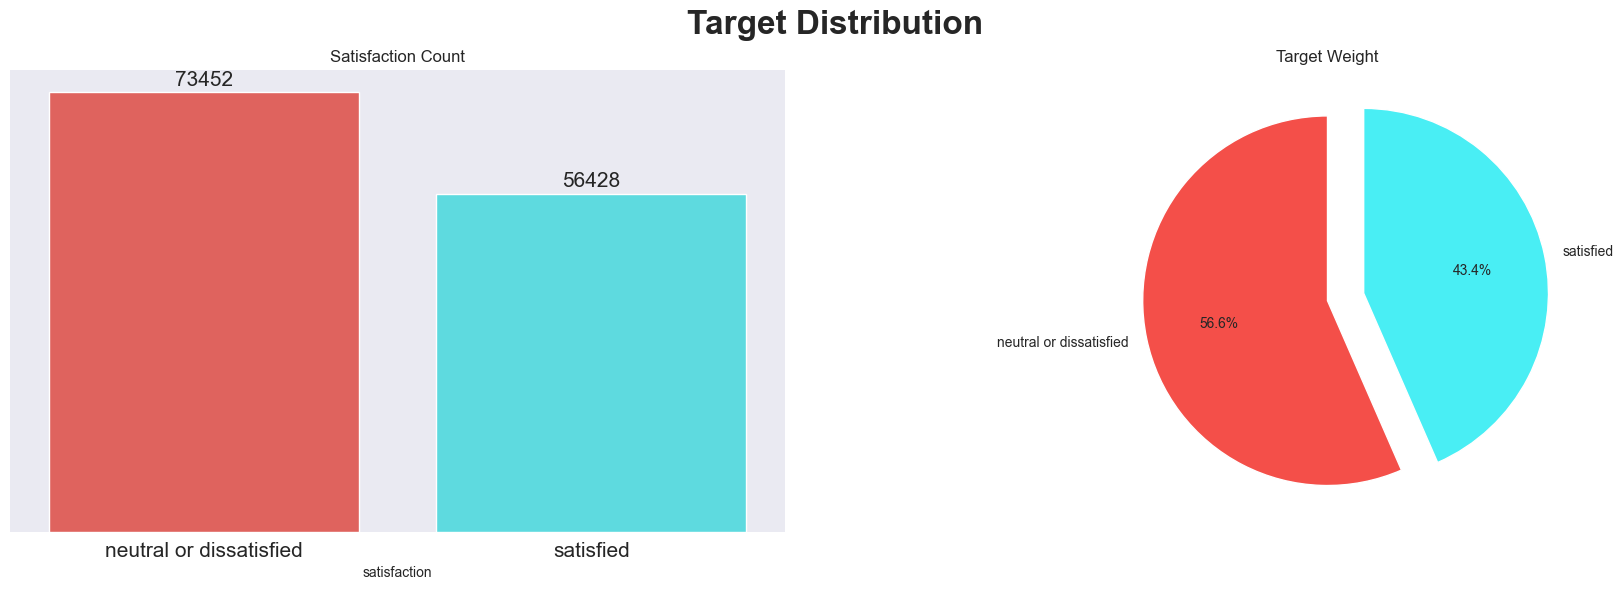

In [6]:
fig = plt.figure(figsize=(22, 6))
plt.suptitle('Target Distribution', weight='bold', fontsize=24, fontname='Arial')

grid = gridspec.GridSpec(nrows=1, ncols=2, figure=fig)

ax1 = fig.add_subplot(grid[0, :1])
ax1.set_title('Satisfaction Count')

sns.countplot(x='satisfaction', data=df, ax=ax1, palette=target_colors)

for spine in ax1.spines.values():
    spine.set_visible(False)
ax1.get_yaxis().set_visible(False)

for index,value in enumerate(df['satisfaction'].value_counts()):
    ax1.annotate(value,xy=(index,value+2000), ha='center', va='center', fontsize=15)
ax1.set_xticklabels(df['satisfaction'].value_counts().index, fontsize=15)
ax2=fig.add_subplot(grid[0, 1:])
ax2.set_title('Target Weight')
label=list(df['satisfaction'].value_counts().index)
value=list(df['satisfaction'].value_counts().values)

ax2.pie(value, labels=label, autopct='%1.1f%%', explode=(0,0.2), startangle =90, colors =target_colors)

plt.show()

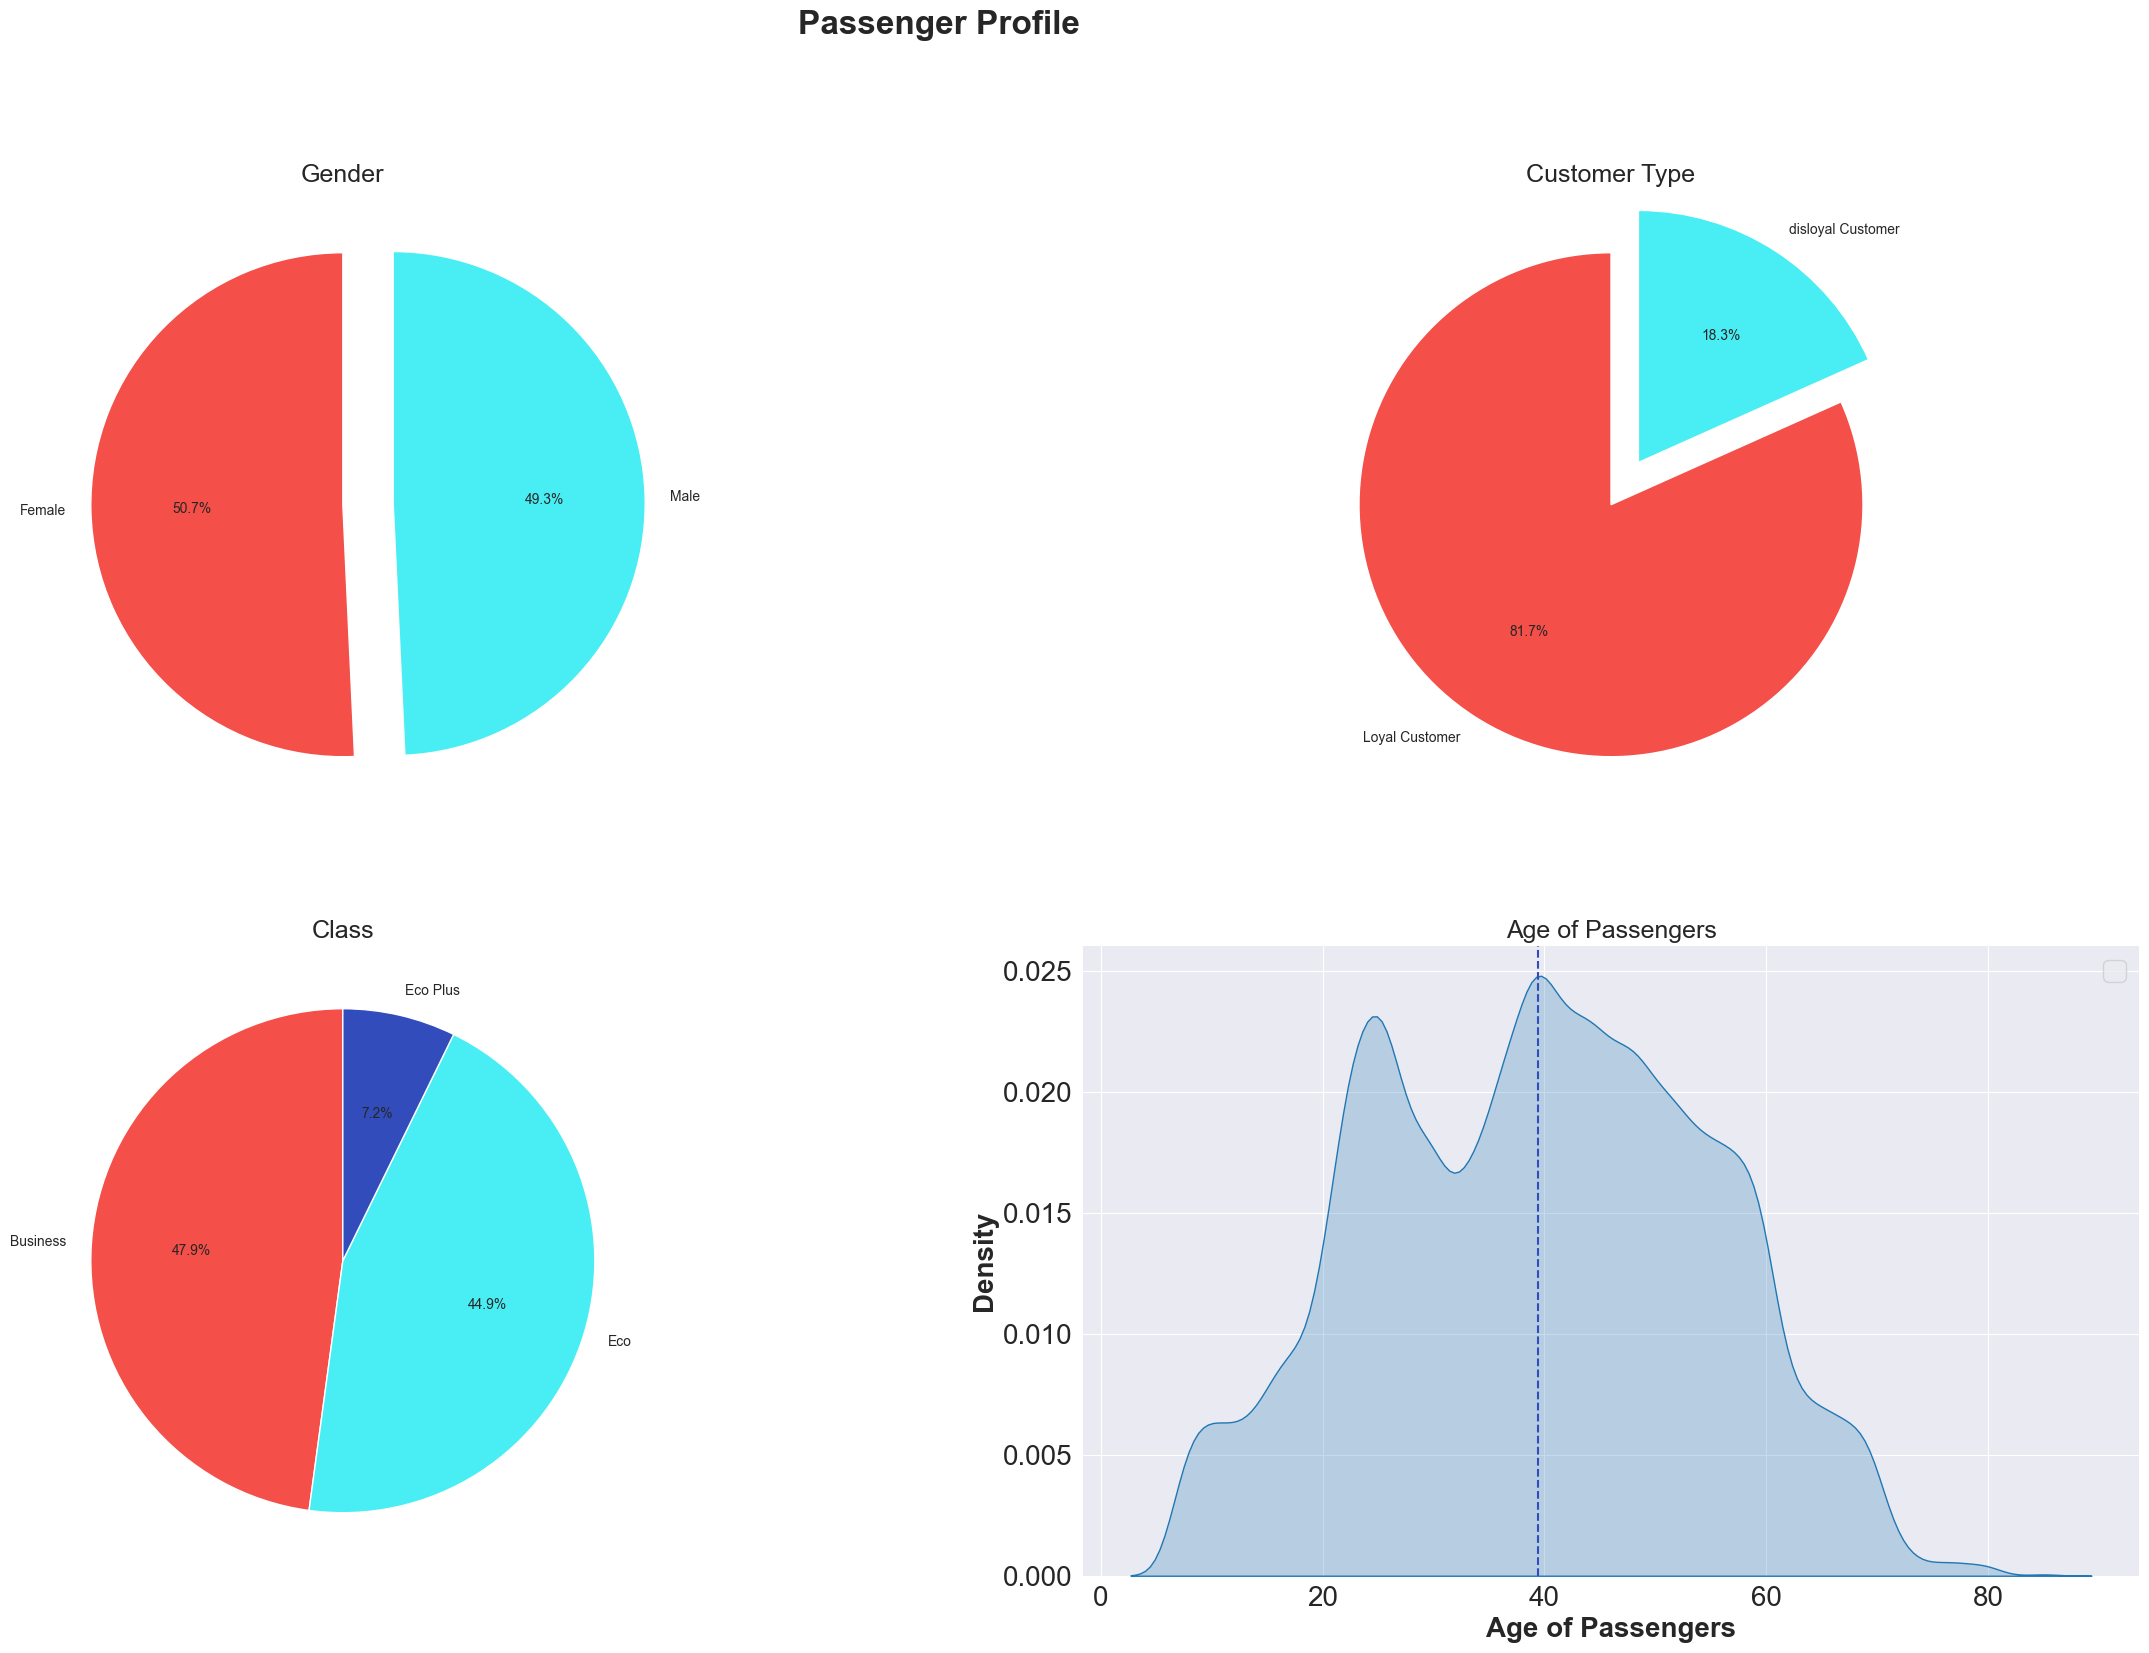

In [7]:
#Passenger Profile
fig = plt.figure(figsize=(30, 18))
plt.suptitle('Passenger Profile', weight='bold', fontsize=24, fontname='Arial')

grid = gridspec.GridSpec(nrows=2, ncols=2, figure=fig)

ax1 = fig.add_subplot(grid[0, :1])
ax1.set_title('Gender', fontsize=18)

label=list(df['Gender'].value_counts().index)
value=list(df['Gender'].value_counts().values)
ax1.pie(value, labels=label, autopct='%1.1f%%', explode=(0,0.2), startangle =90, colors =target_colors)

ax2 = fig.add_subplot(grid[0,1:])
ax2.set_title('Customer Type', fontsize=18)

label=list(df['Customer Type'].value_counts().index)
value=list(df['Customer Type'].value_counts().values)
ax2.pie(value, labels=label, autopct='%1.1f%%', explode=(0,0.2), startangle =90, colors =target_colors)



ax3 = fig.add_subplot(grid[1,:1])
ax3.set_title('Class', fontsize=18)

label=list(df['Class'].value_counts().index)
value=list(df['Class'].value_counts().values)
#pie chart
ax3.pie(value, labels=label, autopct='%1.1f%%', startangle =90, colors =target_colors+['#324DBB'])


ax4 = fig.add_subplot(grid[1,1:])
ax4.set_title('Age of Passengers', fontsize=18)

sns.kdeplot(data=df, x='Age', ax=ax4, fill=True)

ax4.tick_params(axis='x',labelsize = 20)
ax4.tick_params(axis='y',labelsize = 20)

ax4.set_xlabel('Age of Passengers', fontsize=20, weight ='bold')
ax4.set_ylabel('Density', fontsize=20, weight ='bold')

for spine in ax4.spines.values():
    spine.set_visible(False)

ax4.axvline(df['Age'].mean(), linestyle='--', color='#324DBB')
ax4.legend(fontsize=20)

plt.show()

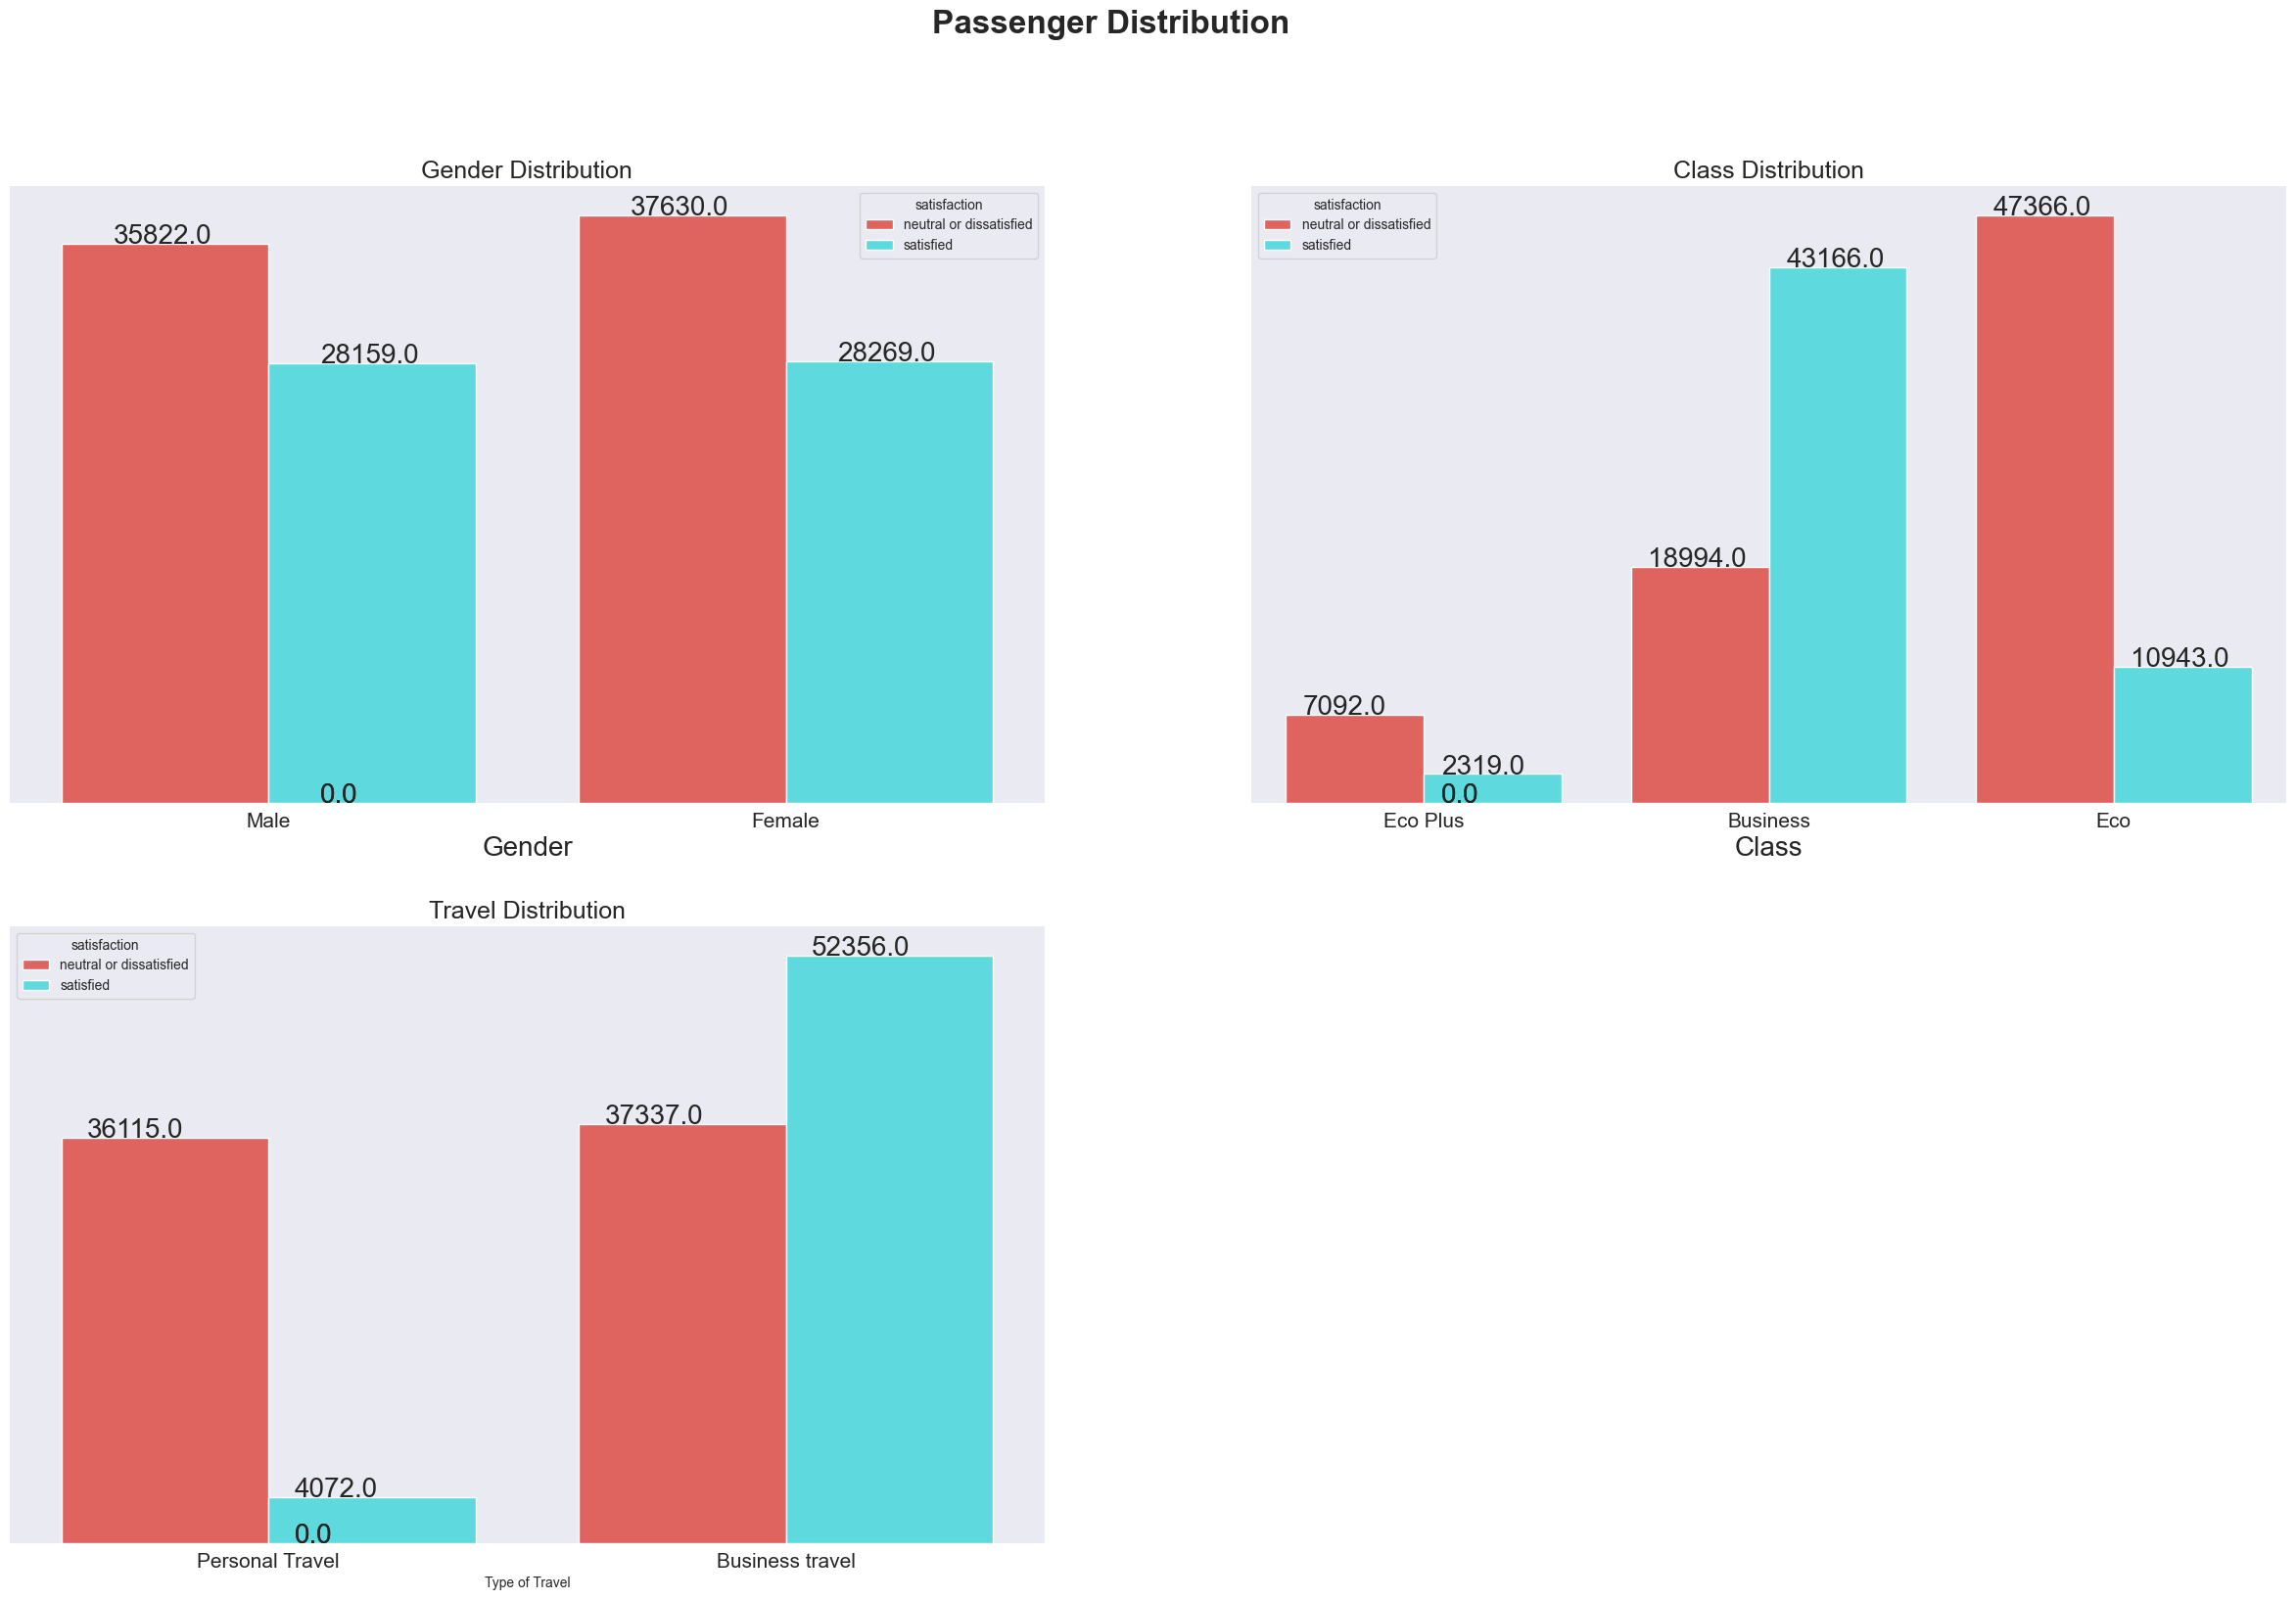

In [8]:
#Satisfaction Corralation with Passenger Profiles
fig = plt.figure(figsize=(30, 18))
plt.suptitle('Passenger Distribution', weight='bold', fontsize=24, fontname='Arial')
grid = gridspec.GridSpec(nrows=2, ncols=2, figure=fig)
ax1 = fig.add_subplot(grid[0, :1])
ax1.set_title('Gender Distribution', fontsize=18)
sns.countplot(x=df['Gender'], hue=df['satisfaction'], ax=ax1, palette=target_colors)
for p in ax1.patches:
    ax1.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.1,p.get_height()), fontsize=20)

ax1.get_yaxis().set_visible(False)
for spine in ax1.spines.values():
    spine.set_visible(False)
ax1.tick_params(axis='x', labelsize=15)
ax1.set_xlabel('Gender', fontsize=20)
grid = gridspec.GridSpec(nrows=2, ncols=2, figure=fig)
ax2 = fig.add_subplot(grid[0, 1:])
ax2.set_title('Class Distribution', fontsize=18)
sns.countplot(x=df['Class'], hue=df['satisfaction'], ax=ax2, palette=target_colors)
for p in ax2.patches:
    ax2.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.05,p.get_height()), fontsize=20)
ax2.get_yaxis().set_visible(False)
for spine in ax2.spines.values():
    spine.set_visible(False)
ax2.tick_params(axis='x', labelsize=15)
ax2.set_xlabel('Class', fontsize=20)
grid = gridspec.GridSpec(nrows=2, ncols=2, figure=fig)
ax3 = fig.add_subplot(grid[1, :1])
ax3.set_title('Travel Distribution', fontsize=18)
sns.countplot(x=df['Type of Travel'], hue=df['satisfaction'], ax=ax3, palette=target_colors)
for p in ax3.patches:
    ax3.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.05,p.get_height()), fontsize=20)
ax3.get_yaxis().set_visible(False)
for spine in ax3.spines.values():
    spine.set_visible(False)
ax3.tick_params(axis='x', labelsize=15)

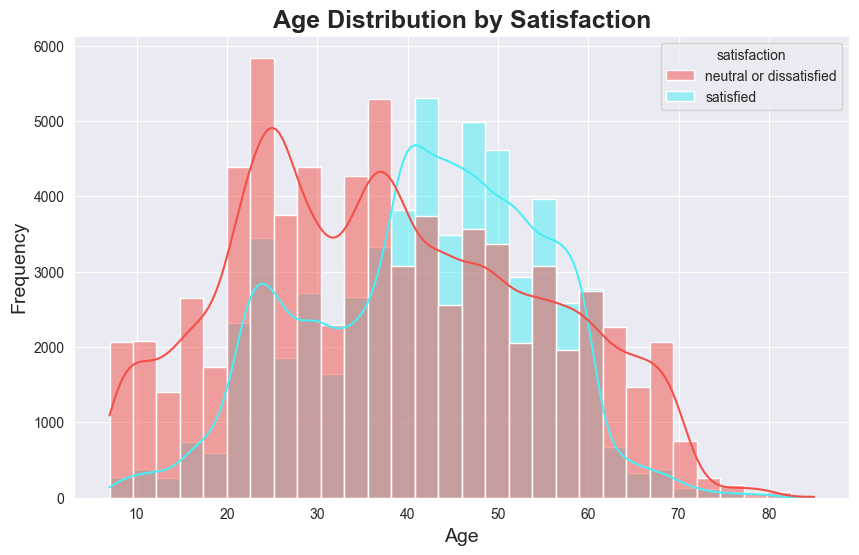

In [9]:
# --- Age Distribution ---
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Age', hue='satisfaction', bins=30, kde=True, palette=target_colors)
plt.title('Age Distribution by Satisfaction', fontsize=18, weight='bold')
plt.xlabel('Age', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

In [10]:
df_copy = df.copy()
df_copy = df.drop(columns=['id', 'Unnamed: 0'])
df_copy.duplicated().sum()

np.int64(0)

In [11]:
X = df_copy.drop(columns=['satisfaction'])
y = df_copy['satisfaction'].map({"neutral or dissatisfied": 0, "satisfied": 1})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [12]:
numerical_features = ['Age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
categorical_features = ['Gender', 'Customer Type', 'Type of Travel', 'Class']

# Create a numerical transformer (Impute + Scale)
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Handle missing values
    ('scaler', StandardScaler())  # Normalize the data
])

# Create a categorical transformer (Impute + OneHotEncode)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Handle missing values
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encoding
])

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [13]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])
param_dist = {
     'classifier__n_estimators': randint(50, 200),  # Random numbers fro 50-200 are chosen
     'classifier__max_depth': [None, 10, 20, 30],  # Choose from these fixed values
     'classifier__min_samples_split': randint(1, 10),  # Randomly choose between 2 and 10
     'classifier__min_samples_leaf': randint(1, 10),  # Randomly choose between 1 and 5
     'classifier__criterion': ['gini', 'entropy'],  # Criterion for splitting nodes
     'classifier__max_features': ['auto', 'sqrt', 'log2'],  # Choose one of these options
     'classifier__bootstrap': [True, False]  # Choose either True or False
}

# Instantiate RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=10,  # Number of random combinations to try
    cv=5,  # Number of cross-validation folds
    scoring='accuracy',  # Scoring method
    n_jobs=-1,  # Use all available cores
    verbose=1,  # Show progress of search
    random_state=42  # Set random state for reproducibility
)

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Get the best model
best_model_rf = random_search.best_estimator_

best_params_rf = random_search.best_params_

y_pred_rf = best_model_rf.predict(X_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [14]:
best_model_rf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Flight Distance',
                                                   'Departure Delay in Minutes',
                                                   'Arrival Delay in Minutes']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Gender', 'Customer Type',
                                                   'Type of Travel',
                                                   'Class'])])),
                ('classifier',
                 RandomForestClassifier(bootstrap=False, criterion='entropy',
                                        max_depth=10, min_samples_leaf=9,
                                        min_samples_split=5, n_estimators=179,
                                        random_state=42))])

In [15]:
#XGB Extreme Gradient Boosting
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

# Define the parameter distributions for Gradient Boosting
param_dist = {
    'classifier__n_estimators': randint(50, 200),  # Number of boosting stages
    'classifier__learning_rate': uniform(0.01, 0.3),  # Learning rate for shrinkage
    'classifier__max_depth': randint(3, 10),  # Depth of each tree
    'classifier__min_samples_split': randint(2, 10),  # Minimum samples to split a node
    'classifier__min_samples_leaf': randint(1, 5),  # Minimum samples in a leaf
    'classifier__subsample': uniform(0.7, 0.3),  # Fraction of samples used for fitting
    'classifier__max_features': ['auto', 'sqrt', 'log2'],  # Features considered for split
}

# Instantiate RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=10,  # Number of random combinations to try
    cv=5,  # Number of cross-validation folds
    scoring='accuracy',  # Scoring metric
    n_jobs=-1,  # Use all available cores
    verbose=1,  # Show progress
    random_state=42  # For reproducibility
)

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Get the best model
best_model_gb = random_search.best_estimator_

best_params_gb = random_search.best_params_

# Make predictions using the best model
y_pred_gb = best_model_gb.predict(X_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [16]:
best_model_gb

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Flight Distance',
                                                   'Departure Delay in Minutes',
                                                   'Arrival Delay in Minutes']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Gender', 'Customer Type',
                                                   'Type of Travel',
                                                   'Class'])])),
                ('classifier',
                 GradientBoostingClassifier(learning_rate=np.float64(0.28279612062363463),
                                            max_depth=6, max_features='sqrt',
                                            min_samples_leaf=4,
                                            min_samples_split=5,
                                            n_estimators=51, random_state=42,
                                            subsample=np.float64(0.8275467623473733)))])

In [17]:
print("Classification Report Random Forest:")
print(classification_report(y_test, y_pred_rf))
print("Classification Report XGB:")
print(classification_report(y_test, y_pred_gb))

Classification Report Random Forest:
              precision    recall  f1-score   support

           0       0.84      0.80      0.82     14622
           1       0.76      0.80      0.78     11354

    accuracy                           0.80     25976
   macro avg       0.80      0.80      0.80     25976
weighted avg       0.80      0.80      0.80     25976

Classification Report XGB:
              precision    recall  f1-score   support

           0       0.84      0.81      0.82     14622
           1       0.77      0.79      0.78     11354

    accuracy                           0.80     25976
   macro avg       0.80      0.80      0.80     25976
weighted avg       0.81      0.80      0.80     25976



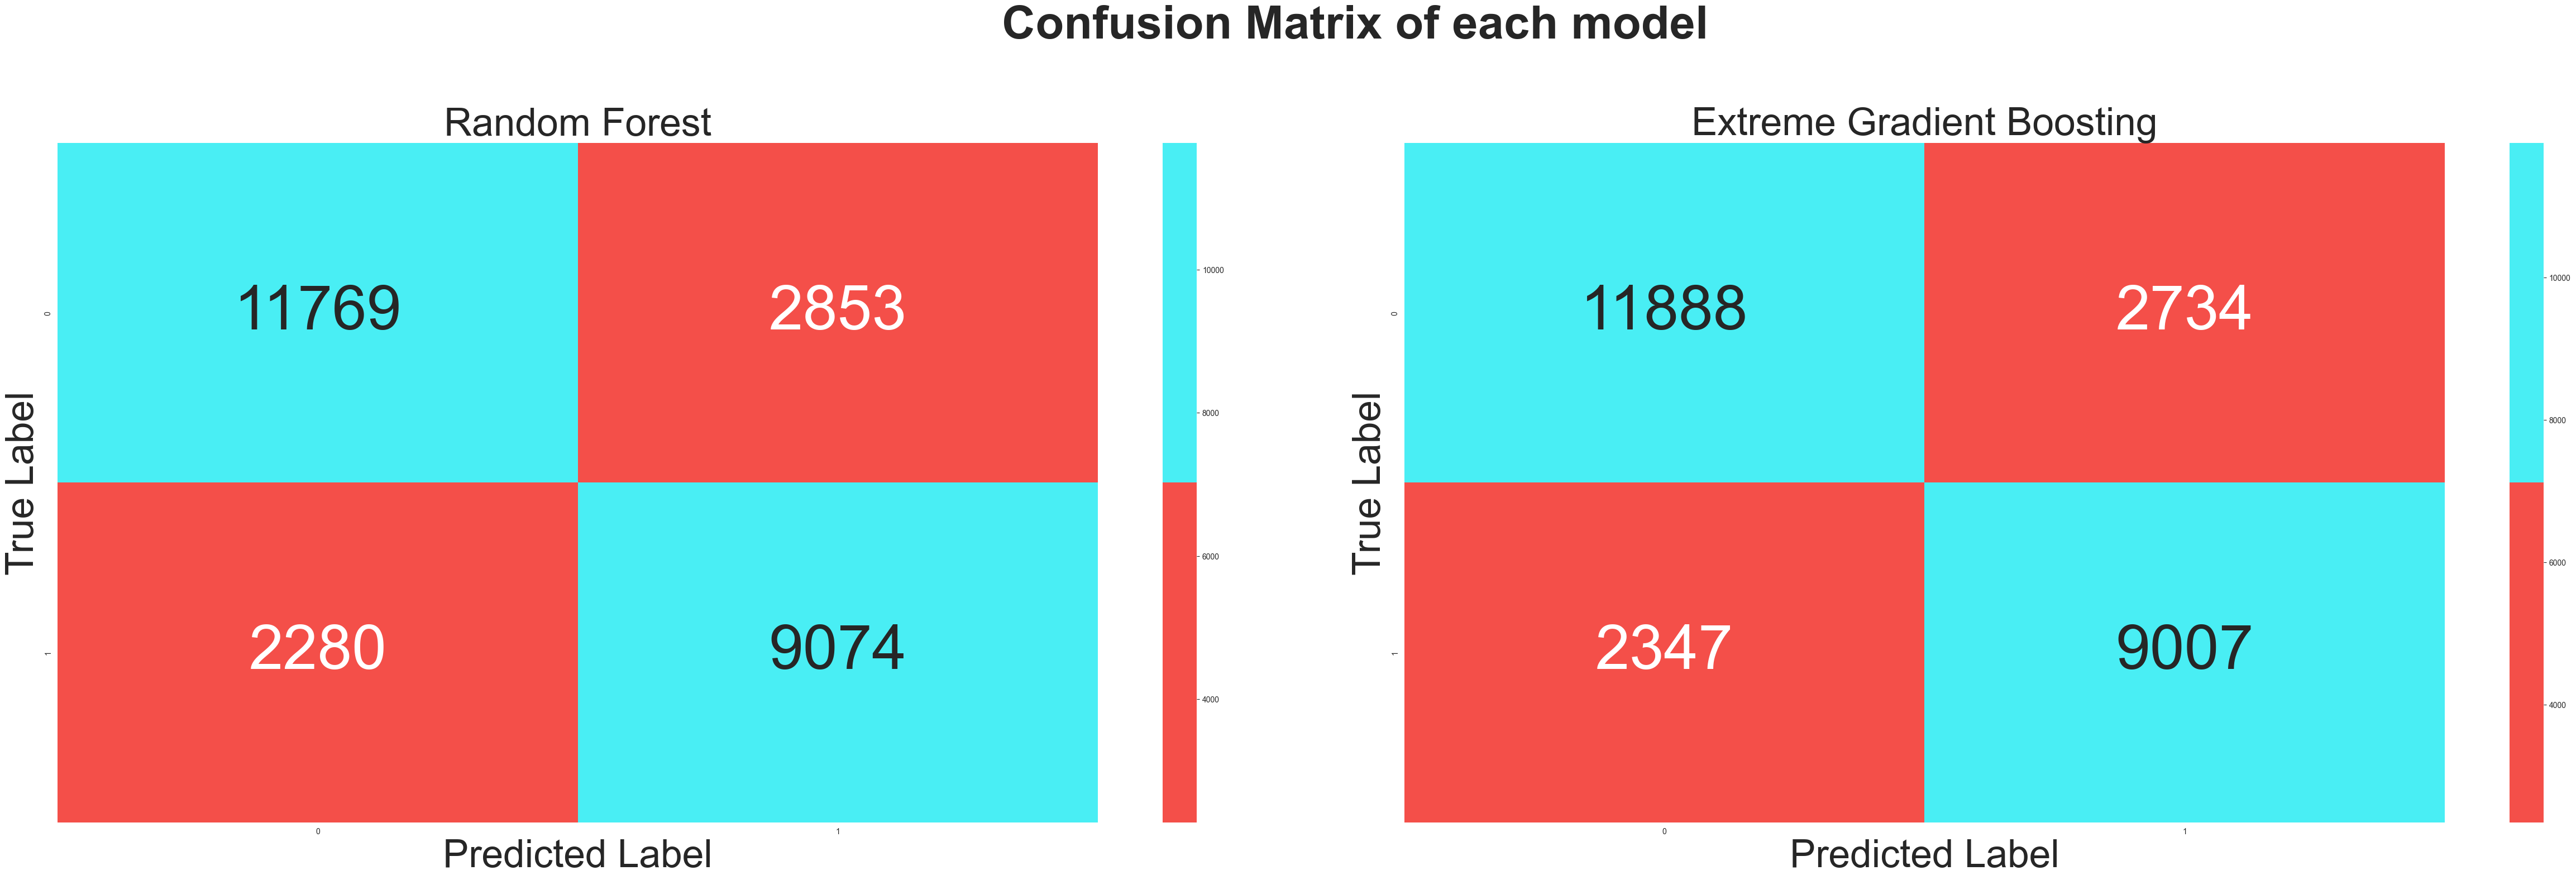

In [18]:
fig = plt.figure(figsize=(50, 30))
plt.suptitle('Confusion Matrix of each model', weight='bold', fontsize=60, fontname='Arial')


grid = gridspec.GridSpec(nrows=2, ncols=2, figure=fig)

# First plot
ax1 = fig.add_subplot(grid[0, 0])
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap=target_colors, ax=ax1,
            annot_kws={"size": 80})  # Larger annotation font size
ax1.set_title('Random Forest', fontsize=50)
ax1.set_xlabel('Predicted Label', fontsize=50)
ax1.set_ylabel('True Label', fontsize=50)

# Second plot
ax2 = fig.add_subplot(grid[0, 1])
sns.heatmap(confusion_matrix(y_test, y_pred_gb), annot=True, fmt='d', cmap=target_colors, ax=ax2,
            annot_kws={"size": 80})  # Larger annotation font size
ax2.set_title('Extreme Gradient Boosting', fontsize=50)
ax2.set_xlabel('Predicted Label', fontsize=50)
ax2.set_ylabel('True Label', fontsize=50)

plt.tight_layout(pad=6.0)
plt.show()